BUILDING A FX QUANTITATIVE SYSTEM

FX trading is one of most competitive markets in the world. Besides other financial instruments, FX makes traditional portfolio managers name it gambling as its difficulty in prediction and high volatility. 

To make it simple we have two approaches when it comes to trading, trend or contra-trend, also called mean reversion strategies. FX it's very corrective, however when a strong trend starts caused by any macroeconomic factor you better surf the trend and not fight against it if you want to survive.

In this notebook I'll expalin my fundamental approach to FX quantitative trading. First we will simplify 45 pairs to 10 currency indices, which will allow us to observe the market desegmented and catch easier the trending pairs and the corrective ones.

Through this notebook I'll explain step by step each process and its logic. Hope you enjoy it.

In [37]:

# import libraries
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from os import listdir
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns
import scipy.signal as signal

# create a file named key.py with token = 'your_oanda_token'
import key

client = API(access_token=key.token)

In [169]:
symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD'] # 45 fx pairs

timeframe = 'D'
lookback = 3000


In order to don't charge to much our pc's RAM we'll create a local database (db) of all the symbols to be analyzed and traded. Each instrument will have it's own csv file and its timeframe folder. It will help later to backtest our model as well.

In [170]:
path = 'db/instruments' # path where to download history data

def db(symbols):

    for sym in symbols:
        print('Downloading '+sym+'...')
        params = { 'granularity': timeframe,'count': lookback }
        r = instruments.InstrumentsCandles(sym, params)
        r = client.request(r)
        date = r['candles'][0]['time'][0:19]
        ret = 0
        df = pd.DataFrame({'date': date, 'return': round(ret, 2)}, index=[0])

        for i in range(1, len(r['candles'])):
            date = r['candles'][i]['time'][0:19]
            #date = r['candles'][i]['time'][0:10]
            #hour = int(r['candles'][i]['time'][11:13])
            ret = round((float(r['candles'][i]['mid']['c']) /
                   float(r['candles'][i]['mid']['o'])-1)*100,2)
            #vol = round((float(r['candles'][i]['mid']['h'])/float(r['candles'][i]['mid']['l'])-1)*100, 2)
            add = pd.DataFrame(
                {'date': date, 'return': ret }, index=[0])
            df = pd.concat([df, add], ignore_index=True)

        Path('db/instruments/'+timeframe).mkdir(parents=True, exist_ok=True)
        df.to_csv('db/instruments/'+timeframe+'/'+sym+'.csv', index=False)


db(symbols)
print('db updated!')



db updated!


Now that we have all the instruments in our folder ( ./db/instruments/'timeframe'/ ) we'll create a function to extract each currency index. The idea is simple: if we want to see the AUD movements, we'll take all the returns in the AUD pairs. I.e: AUD/CAD + AUD/JPY + 1/(EUR/AUD) + ...

In [171]:

def index(currency):

    print('Creating '+currency+'...')
    
    files = [k for k in listdir('db/instruments/'+timeframe) if currency in k]
    df = pd.read_csv('db/instruments/'+timeframe+'/'+files[0])

    if files[0][0:3] != currency:
        df['return'] = -df['return']
    df = df.rename(columns={'return': files[0][0:7]})

    for i in range(1, len(files)):
        df2 = pd.read_csv('db/instruments/'+timeframe+'/'+files[i])
        if files[i][0:3] != currency:
            df2['return'] = -df2['return']
        df2 = df2.rename(columns={'return': files[i][0:7]})
        df = pd.merge(df, df2, on=['date', 'date'])

    df = df.fillna(0)
    df = df.set_index('date')

    df[currency] = round(df.sum(axis=1)/len(currencies), 2)
    df = df[currency]
    Path('db/indexes/'+timeframe).mkdir(parents=True, exist_ok=True)
    df.to_csv('db/indexes/'+timeframe+'/'+currency+'.csv', index=True)


currencies = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'HKD', 'JPY', 'NZD', 'SGD', 'USD']

for curr in currencies:
    index(curr)



Creating AUD...
Creating CAD...
Creating CHF...
Creating EUR...
Creating GBP...
Creating HKD...
Creating JPY...
Creating NZD...
Creating SGD...
Creating USD...


We have created the FX G10 currency indices. Meaning that now we can observe each currency by separate. Let's plot it and see the correlation between them.

In [172]:
idx = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[0]+'.csv')
idx[currencies[0]] = idx[currencies[0]].cumsum()
for i in range(1, len(currencies)):
    df2 = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[i]+'.csv')
    df2[currencies[i]] = df2[currencies[i]].cumsum()
    idx = pd.merge(idx, df2, on=['date', 'date'])

pd.options.plotting.backend = "plotly"
plt = idx.plot(x='date', y=currencies, height=900)
plt.show()


In [173]:
def LowPass(currency):
    # buterworth filter parameters
    N = 2  # filter order
    Wn = 0.1  # cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    # get currency index from db
    df = pd.read_csv('db/indexes/'+timeframe+'/'+currency+'.csv')
    # cumulative sum to create trend
    df[currency] = round(df[currency].cumsum(), 2)
    # apply lowpass filter
    df[currency] = signal.filtfilt(B, A, df[currency])
    return df


sig = LowPass(currencies[0])
for i in range(1,len(currencies)):
    sig = pd.merge(sig, LowPass(currencies[i]), on=['date', 'date'])


plt = sig.plot(title='Signal', x='date', y=currencies, height=600)
plt.show()

idx = idx.set_index('date')
sig = sig.set_index('date')

noise = idx.subtract(sig)

plt = noise.plot(title='Noise', x=noise.index, y=noise.columns, height=600)
plt.show()



In [174]:
noise.sum()

AUD    0.971081
CAD    0.550280
CHF    1.699448
EUR   -0.162871
GBP    0.760873
HKD   -1.255714
JPY   -0.542690
NZD   -0.538293
SGD   -0.716379
USD   -1.363982
dtype: float64

In [175]:
sig.mean()

AUD    -6.795801
CAD    -9.493623
CHF    -1.247027
EUR     1.156327
GBP     5.076774
HKD     8.105792
JPY   -18.036619
NZD     8.081897
SGD     1.897993
USD     9.558205
dtype: float64

In [176]:
some = sig.mean() - noise.sum()

some

AUD    -7.766882
CAD   -10.043904
CHF    -2.946475
EUR     1.319198
GBP     4.315901
HKD     9.361507
JPY   -17.493929
NZD     8.620190
SGD     2.614373
USD    10.922187
dtype: float64

[Text(0.5, 1.0, 'RAW - FX G10 Correlation Matrix\n')]

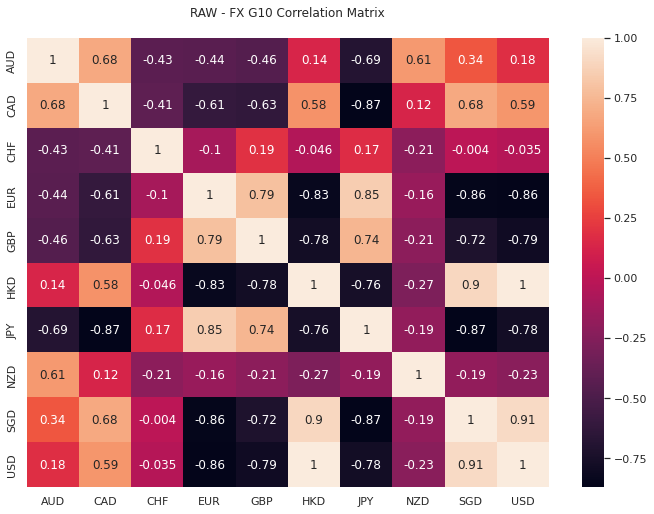

In [103]:
matrix = idx.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
hm1 = sns.heatmap(matrix, annot=True)
hm1.set(title="RAW - FX G10 Correlation Matrix\n")


As we can oberseve some pairs that are currently very correlated, like USD/HKD or SGD/HKD or even EUR/JPY. It can be for multiple reasons, mainly caused by monetary policies. However, all this pairs are perfect for playing mean-reversion strategies. As both currencies are correlated the volatility of the pair will be low, that's why we call it beta pairs.

On the other hand, we have another class of pairs that are negatively correlated. These pairs will be more trendy, as their currencies are going on opposite directions. We'll look for signals to join the trend. We call it alpha pairs as are the most volatile ones.

Last we have the gamma pairs, which are uncorrelated (close to 0). The currencies compounding these pairs have a random relation apparently. Which are perfect for building an uncorrelated portfolio, we can look for trend or corrections.

In [107]:
beta = [] # pairs correlated above 0.75 -> which will be the corrective ones.
alpha = [] # pairs negative correlated below -0.75 -> which will be the tren ones.
gamma = [] # pairs uncorrelated between -0.25 and 0.25 -> which will be the ones we will use to uncorrelated our portfolio in the risk management section.

for base in currencies:
    for term in currencies:
        if base != term:
            if matrix[base][term] > 0.75:
                beta.append(base + '_' + term)
            elif matrix[base][term] < -0.75:
                alpha.append(base + '_' + term)
            elif matrix[base][term] > -0.2 and matrix[base][term] < 0.2:
                gamma.append(base + '_' + term)


beta = [ x for x in beta if x in symbols ]
alpha = [ x for x in alpha if x in symbols ]
gamma = [ x for x in gamma if x in symbols ]


print('\nbeta:', beta, '\nalpha:', alpha, '\ngamma:',gamma)


beta: ['EUR_GBP', 'EUR_JPY', 'SGD_HKD', 'USD_HKD', 'USD_SGD'] 
alpha: ['CAD_JPY', 'EUR_HKD', 'EUR_SGD', 'EUR_USD', 'GBP_HKD', 'GBP_USD', 'HKD_JPY', 'SGD_JPY', 'USD_JPY'] 
gamma: ['AUD_HKD', 'AUD_USD', 'CHF_HKD', 'CHF_JPY', 'EUR_CHF', 'EUR_NZD', 'GBP_CHF', 'NZD_CAD', 'NZD_JPY', 'NZD_SGD', 'SGD_CHF', 'USD_CHF']
